In [11]:
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt
import json


In [9]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from pts.model.tempflow import TempFlowEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from gluonts.dataset.util import to_pandas

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare data set

In [4]:
dataset = get_dataset("solar_nips", regenerate=False)

/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


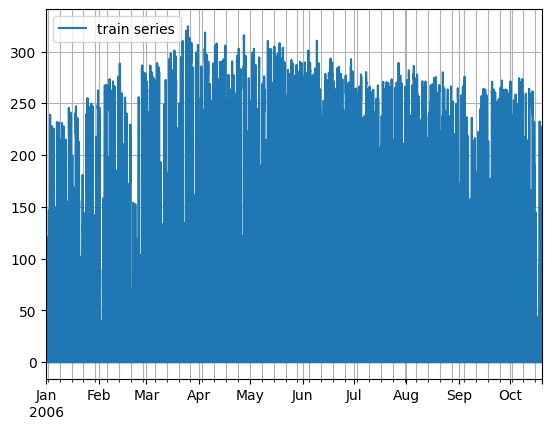

In [12]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


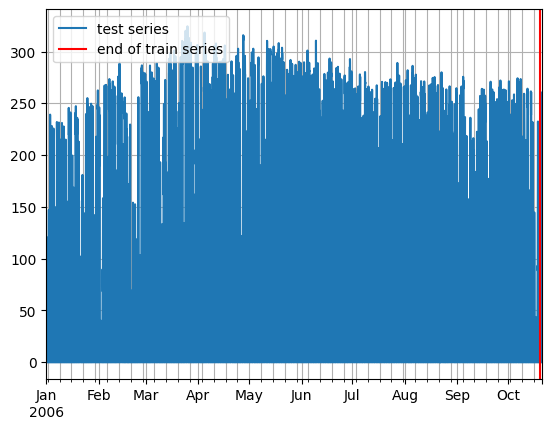

In [13]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [14]:

print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 24
Recommended prediction horizon: 24
Frequency of the time series: H


In [15]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [6]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [7]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users/jangsuhyeok/opt/an

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (959,) + inhomogeneous part.

# Custom Dataset

In [19]:
import os
os.getcwd()

'/Users/jangsuhyeok/Desktop/hackaton_1128/multivariate_flow/pytorch-ts-master/examples'

In [22]:
import pickle
with open("../../../preprocess_data/pickle_final.pkl", 'rb') as f:
    df = pickle.load(f)
df

,GNI,GNI 증감률,전체_사교육비,초등학교_사교육비,중학교_사교육비,고등학교_사교육비,GDP디플레이터_증감률,총지수_증감률,생활물가지수_증감률,신선식품지수_증감률,...,니코틴의존,니코틴금단,주요우울장애,기분부전장애,강박장애,공황장애,광장공포증,사회공포증,범불안장애,특정공포증
1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-01-01,136.0,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-01,138.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,149.0,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-01-01,157.0,5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01,3532.0,1.1,29.1,26.3,31.2,32.1,0.5,1.5,1.6,3.6,...,2.22,0.94,1.58,0.2,0.28,0.16,0.2,0.32,0.4,3.36
2019-01-01,3532.0,0.0,32.1,29.0,33.8,36.5,-0.8,0.4,0.2,-5.1,...,2.28,0.96,1.62,0.2,0.22,0.14,0.2,0.28,0.4,2.94
2020-01-01,3530.0,-0.1,30.2,23.5,34.2,39.6,1.6,0.5,0.4,9.0,...,2.34,0.98,1.66,0.2,0.16,0.12,0.2,0.24,0.4,2.52
2021-01-01,3659.0,3.7,36.7,32.8,39.2,41.9,2.8,2.5,3.2,6.2,...,2.40,1.00,1.70,0.2,0.10,0.10,0.2,0.20,0.4,2.10


In [ ]:
df.info()

## Evaluator

In [14]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

## `GRU-Real-NVP`

In [45]:
estimator = TempFlowEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    scaling=True,
    dequantize=True,
    n_blocks=4,
    trainer=Trainer(device=device,
                    epochs=45,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64)
)

In [46]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

99it [00:10,  9.03it/s, avg_epoch_loss=-43.1, epoch=0]
99it [00:10,  9.03it/s, avg_epoch_loss=-126, epoch=1]
99it [00:11,  9.00it/s, avg_epoch_loss=-142, epoch=2]
99it [00:10,  9.37it/s, avg_epoch_loss=-143, epoch=3]
99it [00:10,  9.09it/s, avg_epoch_loss=-153, epoch=4]
99it [00:11,  8.76it/s, avg_epoch_loss=-157, epoch=5]
99it [00:10,  9.03it/s, avg_epoch_loss=-157, epoch=6]
99it [00:11,  8.94it/s, avg_epoch_loss=-166, epoch=7]
99it [00:11,  8.56it/s, avg_epoch_loss=-169, epoch=8]
99it [00:11,  8.84it/s, avg_epoch_loss=-168, epoch=9]
98it [00:11,  8.89it/s, avg_epoch_loss=-170, epoch=10]
99it [00:11,  8.89it/s, avg_epoch_loss=-172, epoch=11]
98it [00:10,  9.00it/s, avg_epoch_loss=-172, epoch=12]
99it [00:10,  9.02it/s, avg_epoch_loss=-177, epoch=13]
99it [00:10,  9.48it/s, avg_epoch_loss=-180, epoch=14]
98it [00:10,  9.65it/s, avg_epoch_loss=-180, epoch=15]
99it [00:10,  9.01it/s, avg_epoch_loss=-182, epoch=16]
99it [00:10,  9.11it/s, avg_epoch_loss=-182, epoch=17]
99it [00:10,  9.02i

### Metrics

In [47]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.36531966950112466
ND: 0.45434020382814283
NRMSE: 0.9820216603495642
MSE: 914.7868680304274


In [48]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.2873863376280519
ND-Sum: 0.35970480888579265
NRMSE-Sum: 0.7184166842326591
MSE-Sum: 9189074.285714285


## `GRU-MAF`

In [17]:
estimator = TempFlowEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    scaling=True,
    dequantize=True,
    flow_type='MAF',
    trainer=Trainer(device=device,
                    epochs=25,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64)
)

In [18]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

98it [00:10,  9.05it/s, avg_epoch_loss=-7.36, epoch=0]
99it [00:10,  9.19it/s, avg_epoch_loss=-136, epoch=1]
99it [00:10,  9.12it/s, avg_epoch_loss=-164, epoch=2]
98it [00:10,  8.91it/s, avg_epoch_loss=-179, epoch=3]
98it [00:10,  9.09it/s, avg_epoch_loss=-188, epoch=4]
99it [00:10,  9.05it/s, avg_epoch_loss=-194, epoch=5]
98it [00:10,  9.04it/s, avg_epoch_loss=-198, epoch=6]
98it [00:10,  8.97it/s, avg_epoch_loss=-201, epoch=7]
97it [00:10,  8.90it/s, avg_epoch_loss=-204, epoch=8]
99it [00:10,  9.07it/s, avg_epoch_loss=-206, epoch=9]
99it [00:10,  9.09it/s, avg_epoch_loss=-207, epoch=10]
98it [00:11,  8.90it/s, avg_epoch_loss=-209, epoch=11]
99it [00:10,  9.02it/s, avg_epoch_loss=-210, epoch=12]
98it [00:10,  8.95it/s, avg_epoch_loss=-211, epoch=13]
99it [00:10,  9.21it/s, avg_epoch_loss=-212, epoch=14]
98it [00:10,  9.00it/s, avg_epoch_loss=-213, epoch=15]
99it [00:10,  9.21it/s, avg_epoch_loss=-214, epoch=16]
98it [00:10,  8.95it/s, avg_epoch_loss=-215, epoch=17]
98it [00:11,  8.88i

### Metrics

In [19]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.3855313301520275
ND: 0.48820539490099113
NRMSE: 1.018839692673421
MSE: 984.6672641166102


In [20]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.3268739166960563
ND-Sum: 0.40321702146475014
NRMSE-Sum: 0.75586334994103
MSE-Sum: 10171980.5


## `Transformer-MAF`

In [16]:
estimator = TransformerTempFlowEstimator(
    d_model=16,
    num_heads=4,
    input_size=552,
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*4,
    flow_type='MAF',
    dequantize=True,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        device=device,
        epochs=14,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

In [17]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

99it [00:26,  3.70it/s, avg_epoch_loss=-82.7, epoch=0]
Running evaluation: 7it [00:00, 121.58it/s]
Running evaluation: 7it [00:00, 129.89it/s]
Running evaluation: 7it [00:00, 133.02it/s]
Running evaluation: 7it [00:00, 133.71it/s]
Running evaluation: 7it [00:00, 129.68it/s]
Running evaluation: 7it [00:00, 130.11it/s]
Running evaluation: 7it [00:00, 135.91it/s]
Running evaluation: 7it [00:00, 134.94it/s]
Running evaluation: 7it [00:00, 127.03it/s]
Running evaluation: 7it [00:00, 131.79it/s]
Running evaluation: 7it [00:00, 131.80it/s]
Running evaluation: 7it [00:00, 129.62it/s]
Running evaluation: 7it [00:00, 130.80it/s]
Running evaluation: 7it [00:00, 134.32it/s]
Running evaluation: 7it [00:00, 135.98it/s]
Running evaluation: 7it [00:00, 132.59it/s]
Running evaluation: 7it [00:00, 132.17it/s]
Running evaluation: 7it [00:00, 131.03it/s]
Running evaluation: 7it [00:00, 130.69it/s]
Running evaluation: 7it [00:00, 130.72it/s]
Running evaluation: 7it [00:00, 132.53it/s]
Running evaluation: 7

### Metrics

In [11]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.37264046134993567
ND: 0.5043621354947913
NRMSE: 0.9928759300158241
MSE: 935.1208752979203


In [12]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.30787625107438427
ND-Sum: 0.4188356756894787
NRMSE-Sum: 0.7504274205713227
MSE-Sum: 10026199.285714285
